In [1]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.nn.functional import sigmoid
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import random

MODEL_SAVE_DIR = "../ensemble_models_pytorch"
DATA_FILE = '../data/synthetic_ehr_data.csv'
INPUT_DIM = 3
HIDDEN_DIM = 128
OUTPUT_DIM = 1
NUM_LSTM_LAYERS = 2
PLOT_SAVE_DIR = "../plots"
MODEL_INDEX_TO_LOAD = 0 
DROPOUT_PROB = 0.2 if NUM_LSTM_LAYERS > 1 else 0
NUM_MC_SAMPLES = 20
BATCH_SIZE = 32
NUM_WORKERS = 0
PATIENT_INDICES_TO_PLOT = [0, 4, 10, 50, 100]
HIST_X_MAX_LIMIT = 0.6
HIST_NUM_BINS = 15

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
print(f"Loading data from {DATA_FILE}...")
try:
    df = pd.read_csv(DATA_FILE)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: {DATA_FILE} not found.")
    raise

Loading data from data/synthetic_ehr_data.csv...
Data loaded successfully.


In [4]:
print("Preprocessing data into sequences...")
grouped_data = df.groupby('patient_id')
patient_sequences = []
patient_labels = []
feature_cols = ['feature_A', 'feature_B', 'feature_C']
for patient_id, group in grouped_data:
    group = group.sort_values('time_step')
    step_tensors = [torch.tensor(row[feature_cols].values, dtype=torch.float32) for index, row in group.iterrows()]
    if step_tensors:
        patient_sequence_tensor = torch.stack(step_tensors)
        patient_sequences.append(patient_sequence_tensor)
        label = group['outcome'].iloc[0]
        patient_labels.append(torch.tensor([label], dtype=torch.float32))
    else:
        print(f"Warning: Patient {patient_id} has no visit data. Skipping.")
print(f"Processed {len(patient_sequences)} patient sequences.")

Preprocessing data into sequences...
Processed 2000 patient sequences.


In [5]:
class EHRDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]
print("EHRDataset class defined.")

EHRDataset class defined.


In [6]:
def collate_fn(batch):
    sequences = [item[0] for item in batch]
    labels = torch.stack([item[1] for item in batch])
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    return padded_sequences, lengths, labels
print("collate_fn defined.")

collate_fn defined.


In [7]:
ehr_dataset_eval = EHRDataset(patient_sequences, patient_labels)
data_loader_eval = DataLoader(ehr_dataset_eval,
                              batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn,
                              num_workers=NUM_WORKERS)
print(f"Evaluation Dataset created with {len(ehr_dataset_eval)} samples.")
print(f"Evaluation DataLoader created with batch size {BATCH_SIZE}.")

Evaluation Dataset created with 2000 samples.
Evaluation DataLoader created with batch size 32.


In [8]:
class EhrLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(EhrLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        lstm_dropout = DROPOUT_PROB 
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=lstm_dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x, lengths):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        packed_input = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hn, cn) = self.lstm(packed_input, (h0, c0))
        last_hidden_state = hn[-1]
        out = self.fc(last_hidden_state)
        return out
print("EhrLSTM model class defined.")

EhrLSTM model class defined.


In [9]:
print(f"\n--- Loading Pre-trained Model (Index: {MODEL_INDEX_TO_LOAD}) ---")
model_load_path = os.path.join(MODEL_SAVE_DIR, f'pytorch_lstm_model_{MODEL_INDEX_TO_LOAD}.pth')
if not os.path.exists(model_load_path):
    print(f"Error: Model file not found at {model_load_path}.")
    raise FileNotFoundError(f"Model file not found: {model_load_path}")
model = EhrLSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LSTM_LAYERS).to(device)
try:
    state_dict = torch.load(model_load_path, map_location=device)
    model.load_state_dict(state_dict)
    print(f"Successfully loaded model weights from {model_load_path}")
except Exception as e:
    print(f"Error loading model state_dict: {e}")
    raise


--- Loading Pre-trained Model (Index: 0) ---
Successfully loaded model weights from ensemble_models_pytorch\pytorch_lstm_model_0.pth


In [10]:
print("\n--- Starting MC Dropout Evaluation ---")
print(f"Performing {NUM_MC_SAMPLES} forward passes per input...")
model.train() 
all_mc_predictions = []
all_labels_eval = []
eval_start_time = time.time()
with torch.no_grad():
    for batch_idx, (sequences_batch, lengths_batch, labels_batch) in enumerate(data_loader_eval):
        sequences_batch = sequences_batch.to(device)
        labels_batch_np = labels_batch.numpy().flatten()
        all_labels_eval.extend(labels_batch_np)
        batch_mc_preds = np.zeros((sequences_batch.size(0), NUM_MC_SAMPLES))
        for i in range(NUM_MC_SAMPLES):
            outputs = model(sequences_batch, lengths_batch)
            probabilities = sigmoid(outputs).cpu().numpy().flatten()
            batch_mc_preds[:, i] = probabilities
        all_mc_predictions.extend(list(batch_mc_preds))
eval_end_time = time.time()
print(f"MC Dropout prediction generation took: {eval_end_time - eval_start_time:.2f} seconds")
all_mc_predictions_np = np.array(all_mc_predictions)
all_labels_eval_np = np.array(all_labels_eval)
print("\nPrediction generation complete.")
if len(all_labels_eval_np) > 0:
    print(f" Total sequences evaluated: {len(all_labels_eval_np)}")
    print(f" Shape of MC predictions array: {all_mc_predictions_np.shape}")
    print(f" Shape of all labels array: {all_labels_eval_np.shape}")
    print("\nExample MC Dropout Predictions (Probabilities) for first 5 sequences:")
    for p_idx in range(min(5, len(all_labels_eval_np))):
         print(f" Patient {p_idx}: {np.round(all_mc_predictions_np[p_idx, :], 3)}")
    print(f"True Labels: {np.round(all_labels_eval_np[:5], 3)}")
else:
    print("Warning: No predictions were generated.")
print("\nData structures `all_mc_predictions_np` and `all_labels_eval_np` are ready.")



--- Starting MC Dropout Evaluation ---
Performing 20 forward passes per input...
MC Dropout prediction generation took: 2.42 seconds

Prediction generation complete.
 Total sequences evaluated: 2000
 Shape of MC predictions array: (2000, 20)
 Shape of all labels array: (2000,)

Example MC Dropout Predictions (Probabilities) for first 5 sequences:
 Patient 0: [0.266 0.321 0.254 0.258 0.26  0.283 0.263 0.269 0.292 0.286 0.256 0.363
 0.278 0.234 0.302 0.301 0.302 0.284 0.283 0.296]
 Patient 1: [0.209 0.184 0.198 0.191 0.256 0.221 0.176 0.204 0.225 0.189 0.175 0.264
 0.209 0.172 0.169 0.172 0.205 0.202 0.18  0.248]
 Patient 2: [0.138 0.11  0.127 0.152 0.12  0.121 0.142 0.123 0.127 0.119 0.118 0.138
 0.118 0.157 0.127 0.136 0.145 0.124 0.134 0.137]
 Patient 3: [0.36  0.371 0.344 0.319 0.378 0.443 0.362 0.423 0.346 0.397 0.368 0.412
 0.412 0.327 0.325 0.377 0.421 0.4   0.372 0.466]
 Patient 4: [0.142 0.16  0.142 0.158 0.16  0.163 0.143 0.182 0.163 0.168 0.185 0.142
 0.157 0.146 0.152 0.144 


--- Visualizing MC Dropout Uncertainty for Selected Patients ---
Generating histograms using 20 MC samples.
 Saved plot to plots\mc_patient_0_model_0_hist.png


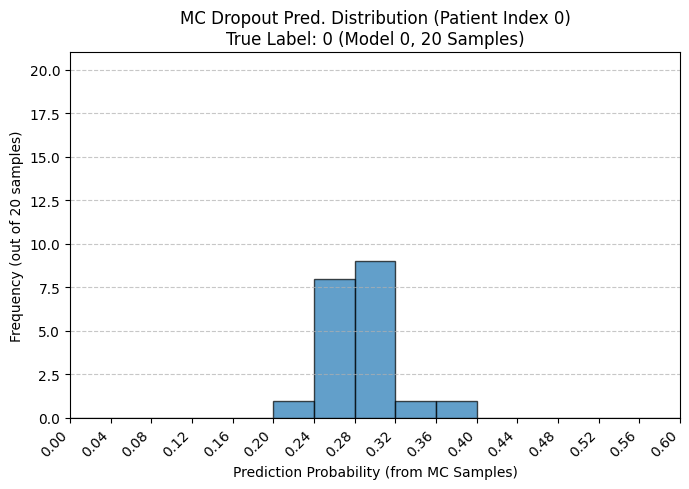

 Saved plot to plots\mc_patient_4_model_0_hist.png


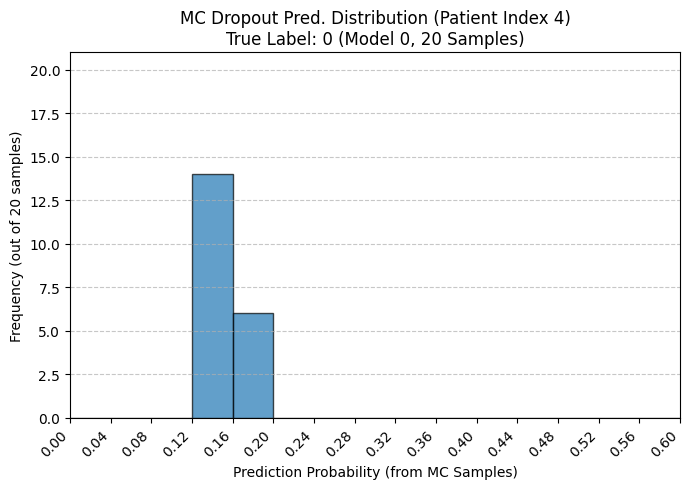

 Saved plot to plots\mc_patient_10_model_0_hist.png


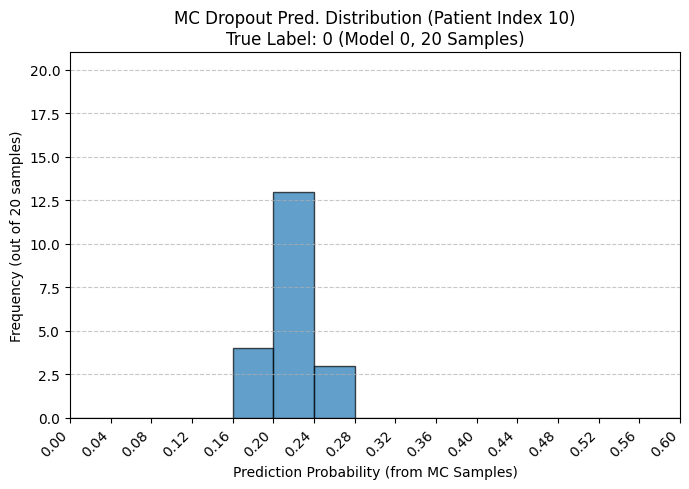

 Saved plot to plots\mc_patient_50_model_0_hist.png


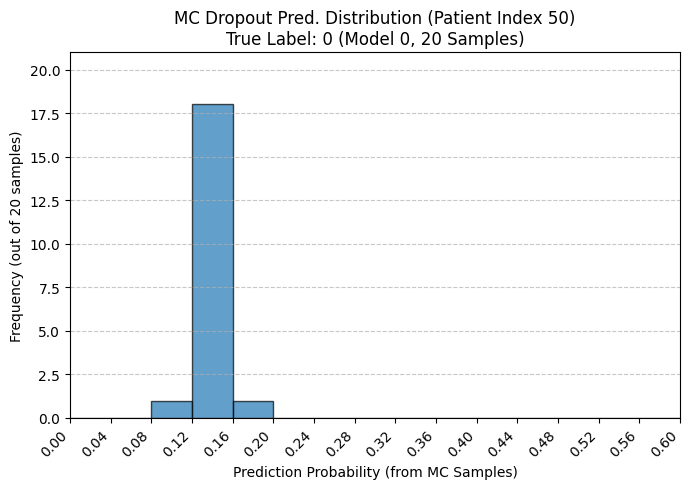

 Saved plot to plots\mc_patient_100_model_0_hist.png


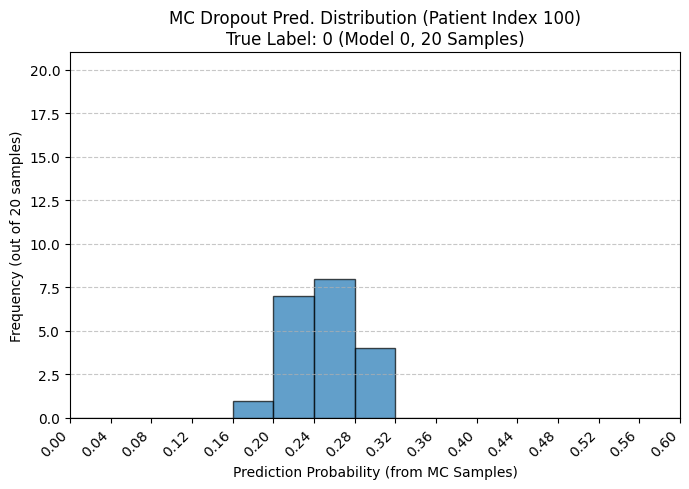


--- MC Dropout Uncertainty Histogram Visualization Complete ---


In [11]:
print("\n--- Visualizing MC Dropout Uncertainty for Selected Patients ---")
bin_edges = np.linspace(0, HIST_X_MAX_LIMIT, HIST_NUM_BINS + 1)
max_index = len(all_labels_eval_np) - 1
valid_indices = [idx for idx in PATIENT_INDICES_TO_PLOT if 0 <= idx <= max_index]
if not valid_indices:
    print("Error: No valid patient indices selected for plotting.")
else:
    print(f"Generating histograms using {NUM_MC_SAMPLES} MC samples.")
    for patient_idx in valid_indices:
        patient_predictions = all_mc_predictions_np[patient_idx, :]
        true_label = all_labels_eval_np[patient_idx]
        plt.figure(figsize=(7, 5))
        plt.hist(patient_predictions, bins=bin_edges, edgecolor='black', alpha=0.7)
        plt.title(f"MC Dropout Pred. Distribution (Patient Index {patient_idx})\nTrue Label: {int(true_label)} (Model {MODEL_INDEX_TO_LOAD}, {NUM_MC_SAMPLES} Samples)")
        plt.xlabel("Prediction Probability (from MC Samples)")
        plt.ylabel(f"Frequency (out of {NUM_MC_SAMPLES} samples)")
        plt.xticks(np.round(bin_edges, 2), rotation=45, ha="right")
        plt.xlim(0, HIST_X_MAX_LIMIT)
        plt.ylim(0, NUM_MC_SAMPLES + 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        hist_figure_path = os.path.join(PLOT_SAVE_DIR, f'mc_patient_{patient_idx}_model_{MODEL_INDEX_TO_LOAD}_hist.png')
        plt.savefig(hist_figure_path, bbox_inches='tight')
        print(f" Saved plot to {hist_figure_path}")
        plt.show()
        plt.close()
print("\n--- MC Dropout Uncertainty Histogram Visualization Complete ---")


--- Generating Mean vs. Standard Deviation Plot (MC Dropout) ---
Calculated mean and std dev for 2000 sequences.
Saved scatter plot to plots\mc_mean_std_dev_scatter_model_0.png


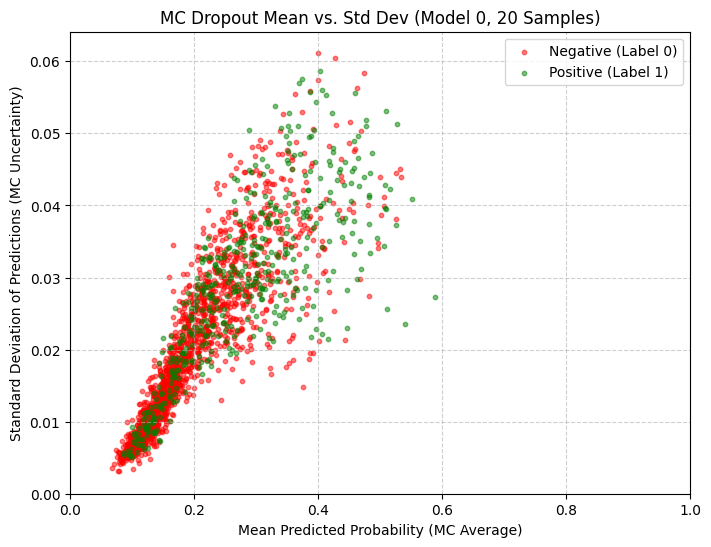


--- MC Dropout Scatter Plot Generation Complete ---


In [14]:
print("\n--- Generating Mean vs. Standard Deviation Plot (MC Dropout) ---")
try:
    mean_mc_predictions = np.mean(all_mc_predictions_np, axis=1)
    std_dev_mc_predictions = np.std(all_mc_predictions_np, axis=1)
    print(f"Calculated mean and std dev for {len(mean_mc_predictions)} sequences.")
    plt.figure(figsize=(8, 6))
    positive_indices = np.where(all_labels_eval_np == 1)[0]
    negative_indices = np.where(all_labels_eval_np == 0)[0]
    plt.scatter(mean_mc_predictions[negative_indices], std_dev_mc_predictions[negative_indices],
                alpha=0.5, s=10, label='Negative (Label 0)', c='red')
    plt.scatter(mean_mc_predictions[positive_indices], std_dev_mc_predictions[positive_indices],
                alpha=0.5, s=10, label='Positive (Label 1)', c='green')
    plt.title(f'MC Dropout Mean vs. Std Dev (Model {MODEL_INDEX_TO_LOAD}, {NUM_MC_SAMPLES} Samples)')
    plt.xlabel('Mean Predicted Probability (MC Average)')
    plt.ylabel('Standard Deviation of Predictions (MC Uncertainty)')
    plt.xlim(0, 1)
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    scatter_figure_path = os.path.join(PLOT_SAVE_DIR, f'mc_mean_std_dev_scatter_model_{MODEL_INDEX_TO_LOAD}.png') 
    print(f"Saved scatter plot to {scatter_figure_path}")
    plt.savefig(scatter_figure_path, bbox_inches='tight') 
    plt.show()
    plt.close()
except Exception as e:
    print(f"An error occurred during scatter plot generation: {e}")
print("\n--- MC Dropout Scatter Plot Generation Complete ---")


In [13]:
print("\n--- Calculating AUC-ROC (MC Dropout Mean) ---")
try:
    if 'mean_mc_predictions' not in locals():
         raise NameError("`mean_mc_predictions` not defined. Run the scatter plot cell.")
    if len(mean_mc_predictions) != len(all_labels_eval_np):
         print(f"Error: Mismatch between mean MC predictions ({len(mean_mc_predictions)}) and labels ({len(all_labels_eval_np)}).")
    else:
        auc_score_mc = roc_auc_score(all_labels_eval_np, mean_mc_predictions)
        print(f"\nMean MC Prediction calculated for {len(mean_mc_predictions)} sequences.")
        print(f"AUC-ROC Score (based on MC mean prediction, Model {MODEL_INDEX_TO_LOAD}): {auc_score_mc:.4f}")
except NameError as e:
     print(f"Error: {e}")
except Exception as e:
    print(f"An error occurred during AUC calculation: {e}")
print("\n--- MC Dropout AUC Calculation Complete ---")


--- Calculating AUC-ROC (MC Dropout Mean) ---

Mean MC Prediction calculated for 2000 sequences.
AUC-ROC Score (based on MC mean prediction, Model 0): 0.7101

--- MC Dropout AUC Calculation Complete ---
